In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### 데이터 개요
- 2개년 시간 별 자전거 대여 수요 데이터 <br>
    - train : 매달 1-19일까지의 데이터 <br> 
    - test : 매달 20- 말일까지의 데이터 (모든 날의 모든 시간대의 Count := 수요를 예측!)

    (Q!) 2년치 데이터에.. train : 10886, test : 6493 개의 데이터가 존재..
    

- columns
    1. season => 1 : spring, 2 : summer, 3 : fall, 4 : winter <br>
    2. weather => 1 : Clear, Partly Cloudy 2: Mist + Cloudy 3. Light Snow or Light Rain 4. Heavy Rain or Snow + Fog
    3. atemp => Feels like temp : 체감 온도
    4. casual / registered : non registered user vs registered user
    5. working day : day is neither a weekend nor holiday
    
#### 평가지표
- RMSLE ( root mean squared logarithm erorr ) <br><br>
$ \sqrt{\frac{1}{𝑛} \times \sum\limits_{i=1}^n (log(𝑝_𝑖+1)−log(𝑎_𝑖+1))^2} $

    - p : predicted / a : actual



In [2]:
train = pd.read_csv("./bike-sharing-demand/train.csv")
test = pd.read_csv("./bike-sharing-demand/test.csv")

In [3]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
train.info() #결측치 없음!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


=> count(demand) 를 직접 예측하는 모델과 casual과 registered를 따로 예측해서 합친 값을 count로 예측하는 두 개의 모델을 만들어 비교해보자

#### Data preprocessing 

* 추후 test data에도 같은 전처리를 적용해야되므로, 함수로 만들기!

1. 날짜 / 계절 / 연휴 데이터 전처리 & 시각화

-   날짜 변환 -> datetime을 year, month, day, hour로 분할 / 요일을 나타내는 column추가

In [6]:
import calendar
from datetime import datetime

day_lst = list(calendar.day_name) 
#['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

def date_preprocessing(df) :
        
    df["t"] = df["datetime"].apply(lambda x: x.split())
    df["date"] = df["t"].apply(lambda x: x[0])
    df['weekday'] = df["t"].apply(lambda x: day_lst[datetime.strptime(x[0],"%Y-%m-%d").weekday()])
    df["weekend"] = df["weekday"].apply(lambda x : 1 if x in ["Saturday", "Sunday"] else 0)
    df["year"] = df["t"].apply(lambda x: int(x[0].split("-")[0]))
    df["month"] = df["t"].apply(lambda x: int(x[0].split("-")[1]))
    df["day"] = df["t"].apply(lambda x: int(x[0].split("-")[2]))

    df["hour"] = df["t"].apply(lambda x: int(x[1].split(":")[0]))
    df = df.drop(["t"], axis=1) 

    return df

In [7]:
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [8]:
train = date_preprocessing(train)
test = date_preprocessing(test)

In [9]:
train['date'] = pd.to_datetime(train['date'])

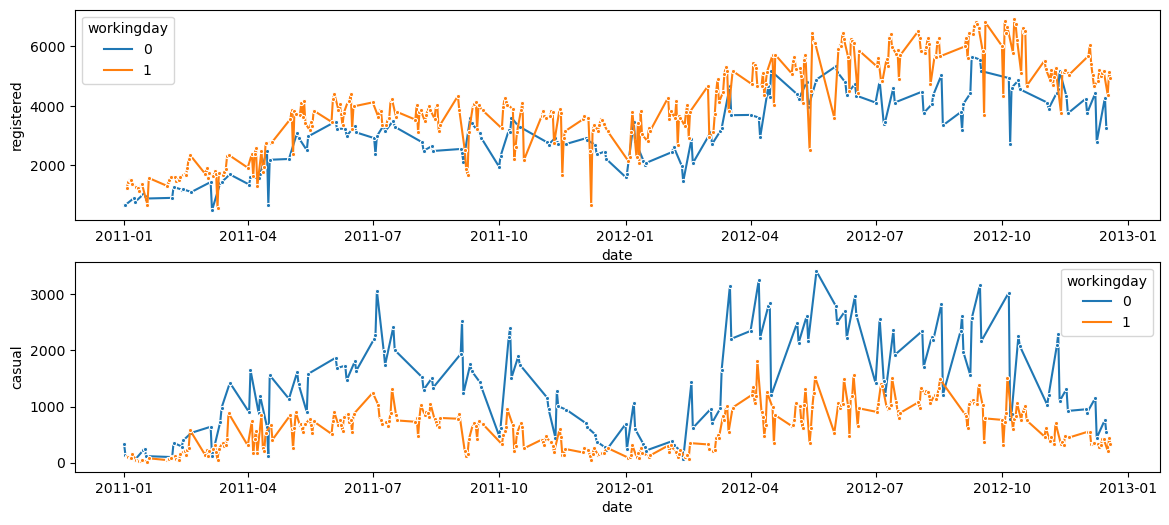

In [10]:
# 시계열 그래프 그리기
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(2,1,1)
ax1 = sns.lineplot(x="date",y="registered",data=train.groupby(["date","workingday"])["registered"].sum().reset_index(), marker='.', hue="workingday")

ax2 = fig.add_subplot(2,1,2)
ax2 = ax1 = sns.lineplot(x="date",y="casual",data=train.groupby(["date","workingday"])["casual"].sum().reset_index(), marker='.', hue="workingday")

In [11]:
train = train.drop(["date"],axis=1)
test = test.drop(["date"],axis=1)

registered와 casual모두 계절성을 띄고 있으나 registered는 꾸준히 증가 추세를 보이는 반면 casual은 확실한 증가 추세가 나타나지 않음 <br>
또, registered는 workingday의 자전거 수요가 높은 반면 casual은 holiday + weekend에 자전거 수요가 높음<br>
(추가적으로 casual->registered로 전환되는 conversion rate을 나타내는 지표가 있었으면 좋았을 것 같음)

In [12]:
train.groupby(["year","weekday","workingday"])["count"].agg(["count","sum","mean"])

count     sum        mean
year weekday   workingday                           
2011 Friday    0              48    6494  135.291667
               1             737  112724  152.949796
     Monday    0              96   15511  161.572917
               1             666  100305  150.608108
     Saturday  0             816  117098  143.502451
     Sunday    0             764  111488  145.926702
     Thursday  1             762  108418  142.280840
     Tuesday   1             773  111848  144.693402
     Wednesday 1             760   98093  129.069737
2012 Friday    1             744  183286  246.352151
     Monday    0             143   28400  198.601399
               1             646  151080  233.869969
     Saturday  0             768  194420  253.151042
     Sunday    0             815  174058  213.568098
     Thursday  1             791  197983  250.294564
     Tuesday   1             766  180137  235.165796
     Wednesday 0              24    7403  308.458333
               1             767  186730  243.455020

In [13]:
train[["season","month"]].value_counts() #123월이 봄..?, 456이 여름..? 789가 가을... 101112가 겨울..?로 표현됨

season  month
2       5        912
        6        912
3       7        912
        8        912
4       12       912
        10       911
        11       911
2       4        909
3       9        909
1       2        901
        3        901
        1        884
Name: count, dtype: int64

In [14]:
#계절을 바르게 바꿔주겠음
train["season"] = train["month"].apply(lambda x: 1 if x//3 == 1 else(2 if x//3 == 2 else (3 if x//3 == 3 else 4)))
test["season"] = test["month"].apply(lambda x: 1 if x//3 == 1 else(2 if x//3 == 2 else (3 if x//3 == 3 else 4)))

In [15]:
train[["season","month"]].value_counts() #123월이 봄..?, 456이 여름..? 789가 가을... 101112가 겨울..?로 표현됨

season  month
1       5        912
2       6        912
        7        912
        8        912
4       12       912
3       10       911
        11       911
1       4        909
3       9        909
1       3        901
4       2        901
        1        884
Name: count, dtype: int64

전반적으로 2021년에 비해 2022년의 자전거 수요가 증가했고, 2011년은 유독 수요일의 대여 수요가 적었지만 2022년은 일요일의 수요가 낮은 편으로 보여짐 <br>
-> 좀 더 직관적으로 보기 위해 시각화 내용 추가!

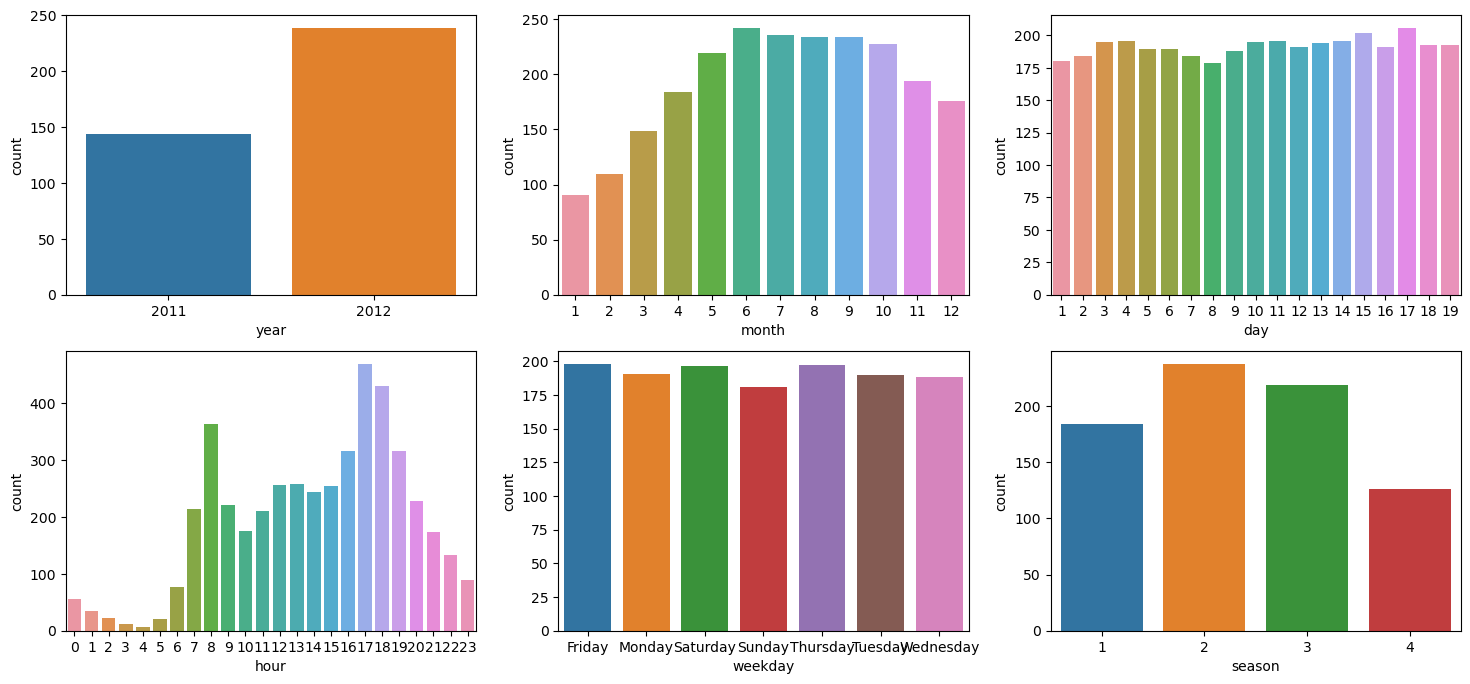

In [16]:
fig = plt.figure(figsize=[18,8])

ax1 = fig.add_subplot(2,3,1)
ax1 = sns.barplot(x="year", y="count", data=train.groupby("year")["count"].mean().reset_index())

ax2 = fig.add_subplot(2,3,2)
ax2 = sns.barplot(x="month", y="count", data=train.groupby("month")["count"].mean().reset_index())

ax3 = fig.add_subplot(2,3,3)
ax3 = sns.barplot(x="day", y="count", data=train.groupby("day")["count"].mean().reset_index())

ax4 = fig.add_subplot(2,3,4)
ax4 = sns.barplot(x="hour", y="count", data=train.groupby("hour")["count"].mean().reset_index())

ax5 = fig.add_subplot(2,3,5)
ax5 = sns.barplot(x="weekday", y="count", data=train.groupby("weekday")["count"].mean().reset_index())

ax6 = fig.add_subplot(2,3,6)
ax6 = sns.barplot(x="season", y="count", data=train.groupby("season")["count"].mean().reset_index())


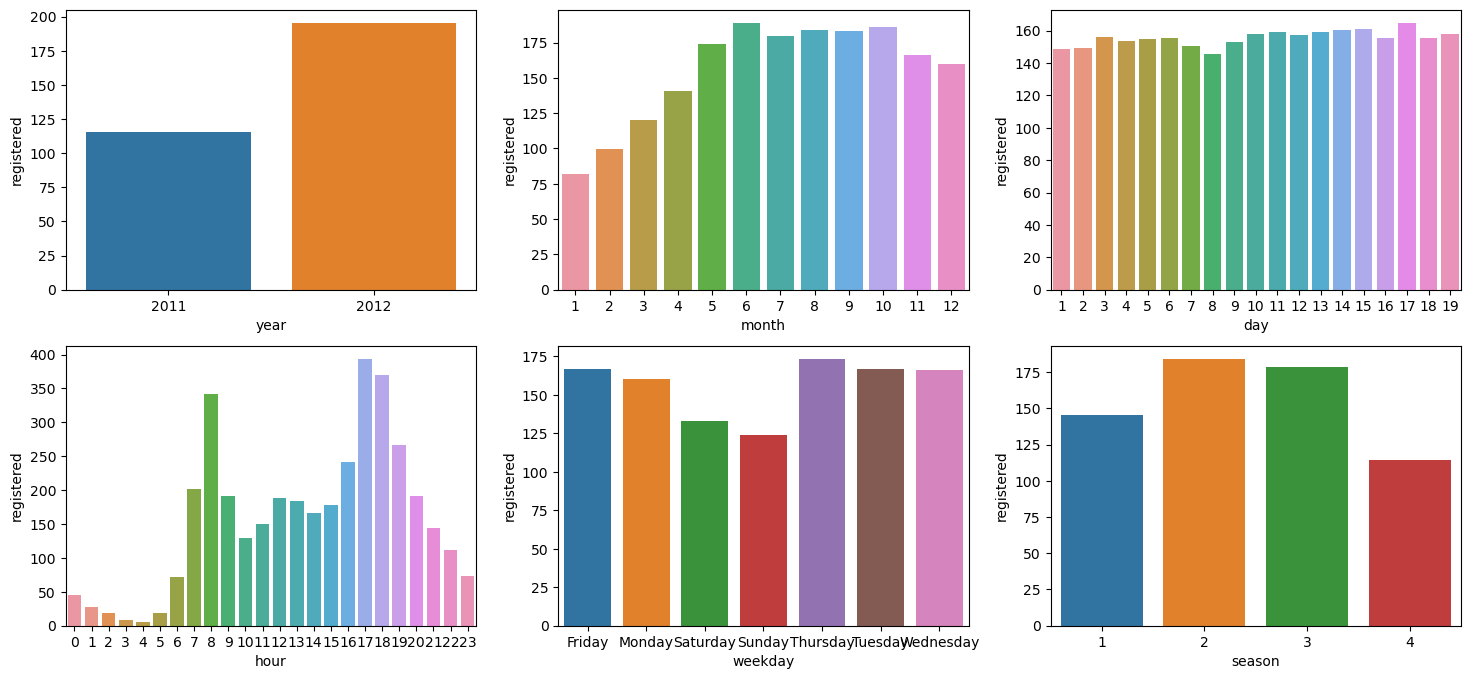

In [17]:
fig = plt.figure(figsize=[18,8])

ax1 = fig.add_subplot(2,3,1)
ax1 = sns.barplot(x="year", y="registered", data=train.groupby("year")["registered"].mean().reset_index())

ax2 = fig.add_subplot(2,3,2)
ax2 = sns.barplot(x="month", y="registered", data=train.groupby("month")["registered"].mean().reset_index())

ax3 = fig.add_subplot(2,3,3)
ax3 = sns.barplot(x="day", y="registered", data=train.groupby("day")["registered"].mean().reset_index())

ax4 = fig.add_subplot(2,3,4)
ax4 = sns.barplot(x="hour", y="registered", data=train.groupby("hour")["registered"].mean().reset_index())

ax5 = fig.add_subplot(2,3,5)
ax5 = sns.barplot(x="weekday", y="registered", data=train.groupby("weekday")["registered"].mean().reset_index())

ax6 = fig.add_subplot(2,3,6)
ax6 = sns.barplot(x="season", y="registered", data=train.groupby("season")["registered"].mean().reset_index())


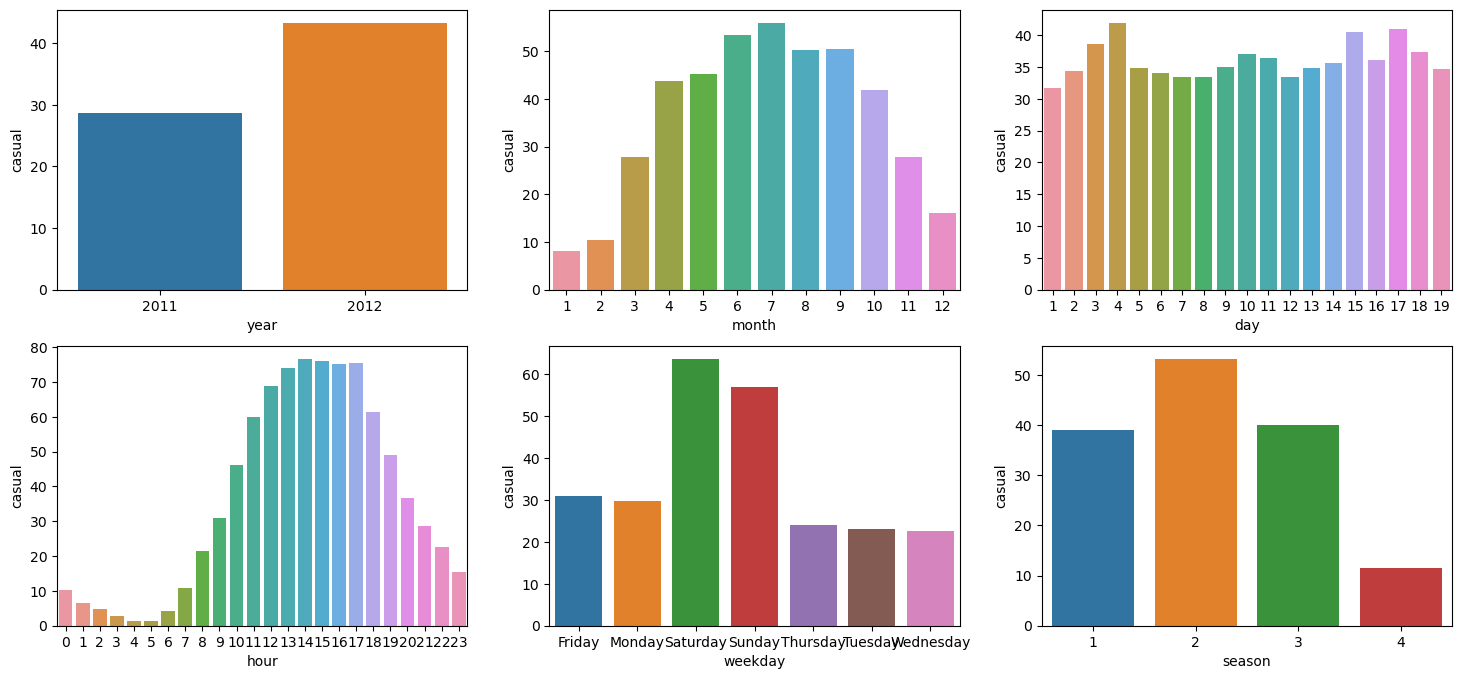

In [18]:
fig = plt.figure(figsize=[18,8])

ax1 = fig.add_subplot(2,3,1)
ax1 = sns.barplot(x="year", y="casual", data=train.groupby("year")["casual"].mean().reset_index())

ax2 = fig.add_subplot(2,3,2)
ax2 = sns.barplot(x="month", y="casual", data=train.groupby("month")["casual"].mean().reset_index())

ax3 = fig.add_subplot(2,3,3)
ax3 = sns.barplot(x="day", y="casual", data=train.groupby("day")["casual"].mean().reset_index())

ax4 = fig.add_subplot(2,3,4)
ax4 = sns.barplot(x="hour", y="casual", data=train.groupby("hour")["casual"].mean().reset_index())

ax5 = fig.add_subplot(2,3,5)
ax5 = sns.barplot(x="weekday", y="casual", data=train.groupby("weekday")["casual"].mean().reset_index())

ax6 = fig.add_subplot(2,3,6)
ax6 = sns.barplot(x="season", y="casual", data=train.groupby("season")["casual"].mean().reset_index())

절대적으론 registered(등록 고객)이 많은 수를 차지해 count로 보면 causal한 고객들의 특성이 반영되지 않는 것을 고려해 두 가지 경우를 나눠서 시각화를 진행함

2021년에 비해 2022년에 두 종류의 고객 모두에서 증가세를 보임, 또한 겨울에는 자전거 대여 수요가 크게 감소함

registered는 출퇴근용, casual은 나들이용으로 자전거 대여를 이용함! 

registered는 주중과, 출퇴근 시간대인 8시와 17-18에 가장 많은 대여가 발생하는 반면 casual은 주말에 2배 이상의 대여가 발생함
또한, 12-16사이 대여 현황에서 뚜렷한 경향성이 나타나지 않았음 

month를 보면 registered에 비해 casual이 계절성에 더 큰 영향을 많이 받는 것으로 보임

-> 평일 10-15사이에 대여하는 등록되지 않은 고객(casual)에게 할인쿠폰을 제공한다면 매출 증대를 이룰 수 있을 것으로 보임

In [19]:
train[["holiday","workingday","weekend"]].value_counts() #holiday와 working day만 보고도 weekend의 여부를 알 수 있으므로 model에 weekend 변수는 넣어주지 않아도 됨!

holiday  workingday  weekend
0        1           0          7412
         0           1          3163
1        0           0           311
Name: count, dtype: int64

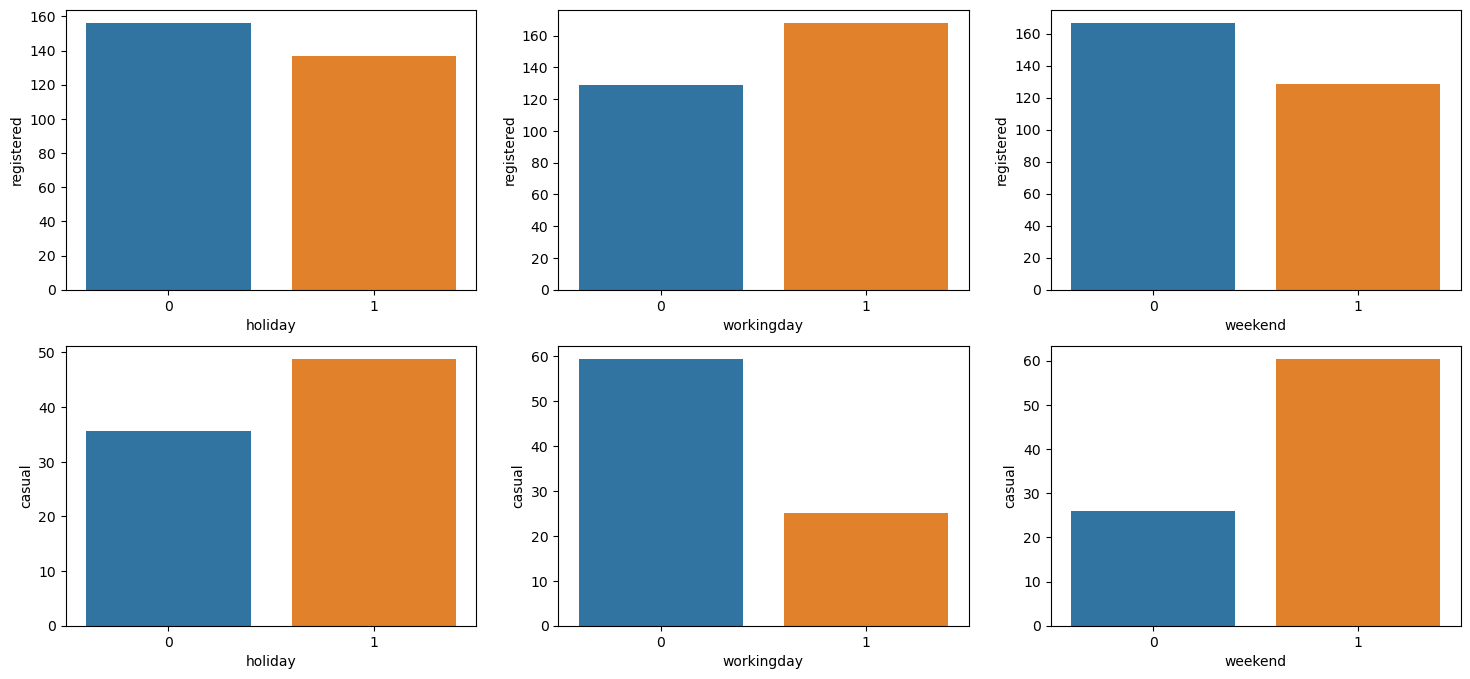

In [20]:
fig = plt.figure(figsize=[18,8])

ax1 = fig.add_subplot(2,3,1)
ax1 = sns.barplot(x="holiday", y="registered", data=train.groupby("holiday")["registered"].mean().reset_index())

ax2 = fig.add_subplot(2,3,2)
ax2 = sns.barplot(x="workingday", y="registered", data=train.groupby("workingday")["registered"].mean().reset_index())

ax3 = fig.add_subplot(2,3,3)
ax3 = sns.barplot(x="weekend", y="registered", data=train.groupby("weekend")["registered"].mean().reset_index())

ax4 = fig.add_subplot(2,3,4)
ax4 = sns.barplot(x="holiday", y="casual", data=train.groupby("holiday")["casual"].mean().reset_index())

ax5 = fig.add_subplot(2,3,5)
ax5 = sns.barplot(x="workingday", y="casual", data=train.groupby("workingday")["casual"].mean().reset_index())

ax6 = fig.add_subplot(2,3,6)
ax6 = sns.barplot(x="weekend", y="casual", data=train.groupby("weekend")["casual"].mean().reset_index())


registered와 casual은 완전히 정반대의 양상을 가짐 <br>
registered와 casual을 다르게 예측하는 모델을 제작해야될 것으로 보여짐!

In [21]:
train.groupby("weather")["count"].agg(["count","sum","mean"]) 

,count,sum,mean
weather,,,
1,7192,1476063,205.236791
2,2834,507160,178.955540
3,859,102089,118.846333
4,1,164,164.000000


In [22]:
test[test["weather"] == 4]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,weekday,weekend,year,month,day,hour
154,2011-01-26 16:00:00,4,0,1,4,9.02,9.85,93,22.0028,Wednesday,0,2011,1,26,16
3248,2012-01-21 01:00:00,4,0,0,4,5.74,6.82,86,12.9980,Saturday,1,2012,1,21,1


우박이 올 정도로 날씨가 좋지 않은 날의 데이터는 한 개 밖에 존재하지 않음! <br>
그러나 테스트 데이터에도 weather==4인 경우가 존재하기 때문에 누락할 수 없음 <br>
-> 그러나 모델 성능에 영향을 주진않을 것임!

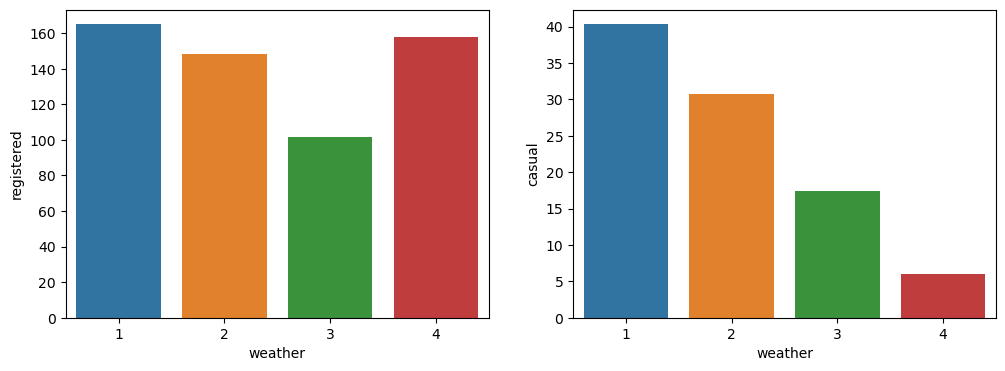

In [23]:
fig = plt.figure(figsize=[12,4])

ax1 = fig.add_subplot(1,2,1)
ax1 = sns.barplot(x="weather", y="registered", data=train.groupby("weather")["registered"].mean().reset_index())

ax2 = fig.add_subplot(1,2,2)
ax2 = sns.barplot(x="weather", y="casual", data=train.groupby("weather")["casual"].mean().reset_index())

확실히 casual이 날씨의 영향을 더욱 많이 받음

2. 나머지 변수인 여러 연속형 변수들에 대해 (temp, atemp, humidity, windspeed) 전처리 & 시각화 

In [24]:
selected = train[["temp","atemp","humidity","windspeed","registered","casual","count"]]

In [25]:
selected.corr()

,temp,atemp,humidity,windspeed,registered,casual,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.318571,0.467097,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.314635,0.462067,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.265458,-0.348187,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.091052,0.092276,0.101369
registered,0.318571,0.314635,-0.265458,0.091052,1.000000,0.497250,0.970948
casual,0.467097,0.462067,-0.348187,0.092276,0.497250,1.000000,0.690414
count,0.394454,0.389784,-0.317371,0.101369,0.970948,0.690414,1.000000


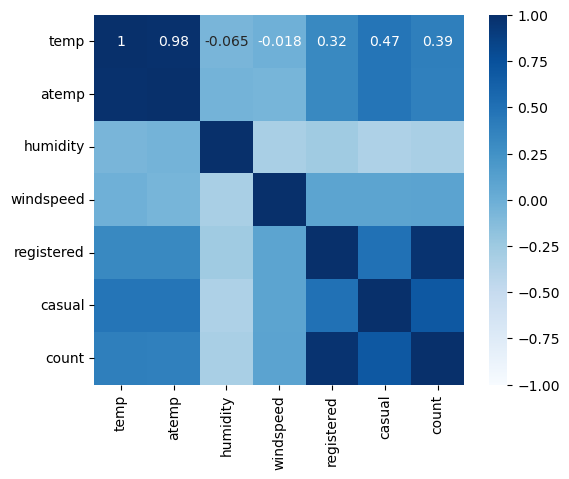

In [26]:
sns.heatmap(selected.corr(), annot=True, cmap='Blues', square=True, vmax=1, vmin=-1)
plt.show()

temp와 atemp를 제외하곤 상관관계가 높은 지표가 없음 temp가 atemp에 비해 registered, casual, count모든 종속변인에 대해 소폭 높은 상관계수를 지님으로 atemp를 drop해줌 <br>
registered에 비해 casual에게 온도는 자전거 수요에 더 큰 영향을 미침

In [27]:
train = train.drop(["atemp","weekend"], axis=1)
test = test.drop(["atemp","weekend"], axis=1)

변수형 데이터와 연속형 데이터 간의 관계를 파악해봄

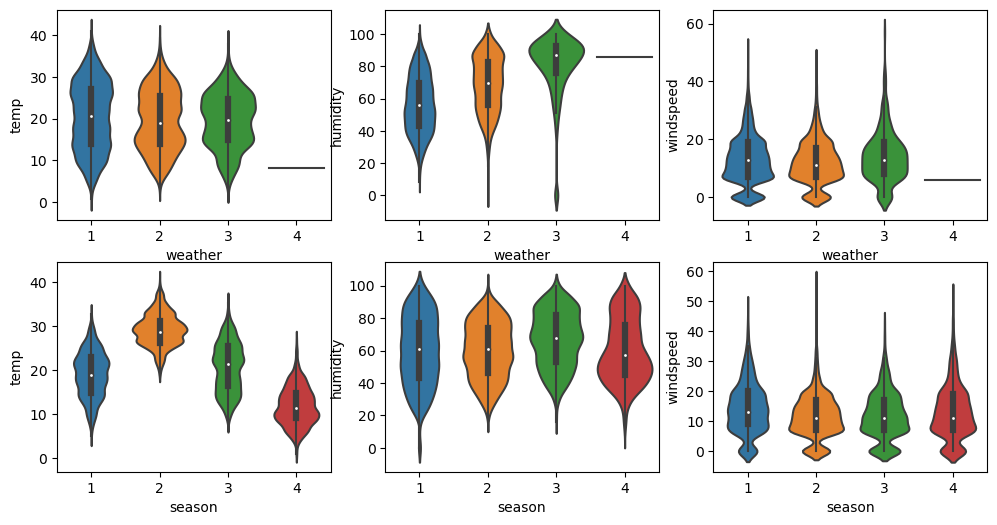

In [28]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(2,3,1)
ax1 =sns.violinplot(x="weather",y="temp",data=train)

ax2 = fig.add_subplot(2,3,2)
ax2 =sns.violinplot(x="weather",y="humidity",data=train)

ax3 = fig.add_subplot(2,3,3)
ax3 =sns.violinplot(x="weather",y="windspeed",data=train)

ax4 = fig.add_subplot(2,3,4)
ax4 =sns.violinplot(x="season",y="temp",data=train)

ax5 = fig.add_subplot(2,3,5)
ax5 =sns.violinplot(x="season",y="humidity",data=train)

ax6 = fig.add_subplot(2,3,6)
ax6 =sns.violinplot(x="season",y="windspeed",data=train)


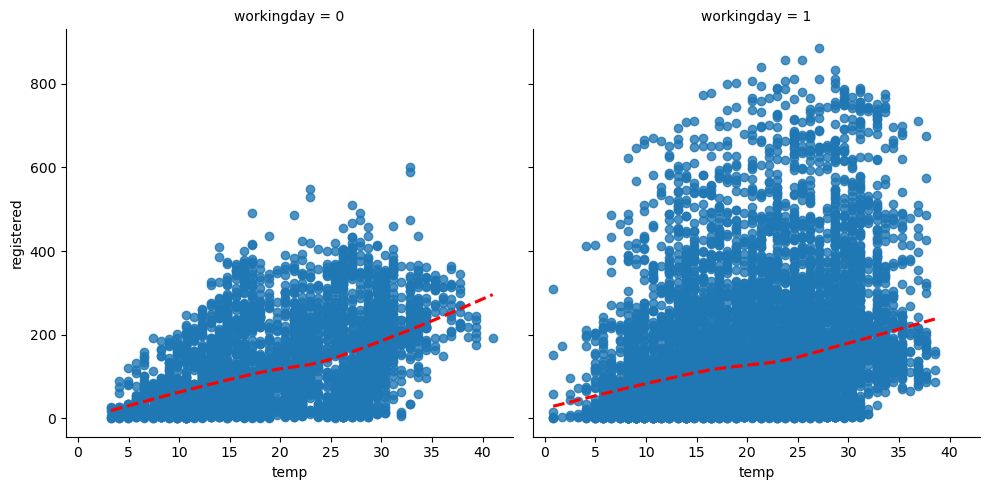

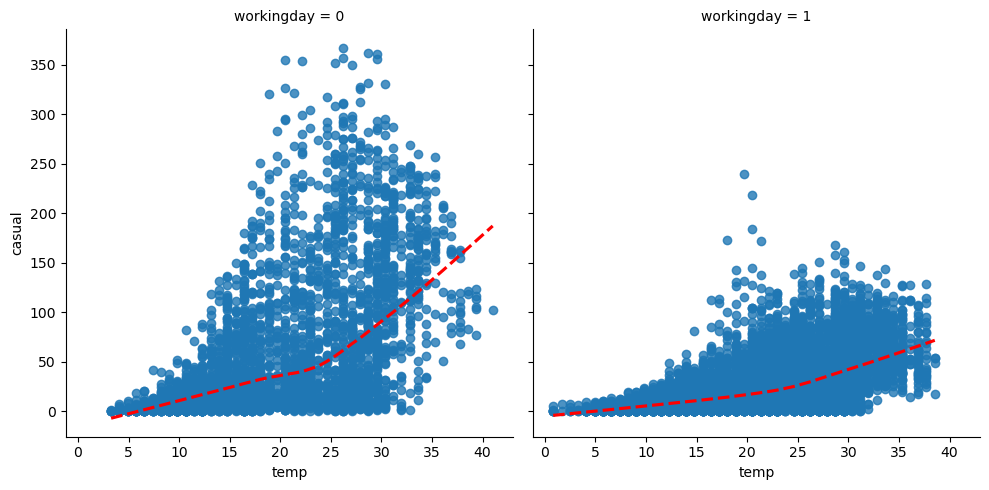

In [29]:
ax1 = fig.add_subplot(2,1,1)
ax1 = sns.lmplot(x ="temp",y="registered",data=train, col="workingday",lowess=True, line_kws={"color":"red","linestyle":"dashed"})

ax2 = fig.add_subplot(2,1,2)
ax2 = sns.lmplot(x ="temp",y="casual",data=train, col="workingday",lowess=True, line_kws={"color":"red","linestyle":"dashed"})

온도가 상승할수록 자전거 대여가 상승하는 경향이 있고, 특히 등록되지 않은 회원들에게서 쉬는 날 온도에 따른 자전거 수요의 상승의 폭이 더 크게 나타남 -> 교호작용을 고려해봐야됨!

종속변인의 값을 Histogram으로 표현

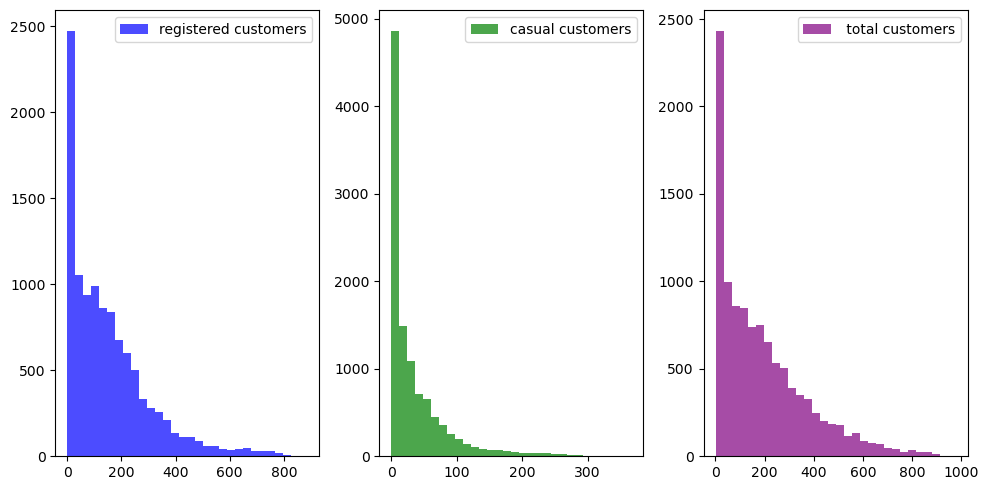

In [30]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.hist(train["registered"], bins=30, alpha=0.7, color='blue', label='registered customers')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(train['casual'], bins=30, alpha=0.7, color='green', label='casual customers')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(train['count'], bins=30, alpha=0.7, color='purple', label=' total customers')
plt.legend()


plt.tight_layout()
plt.show()

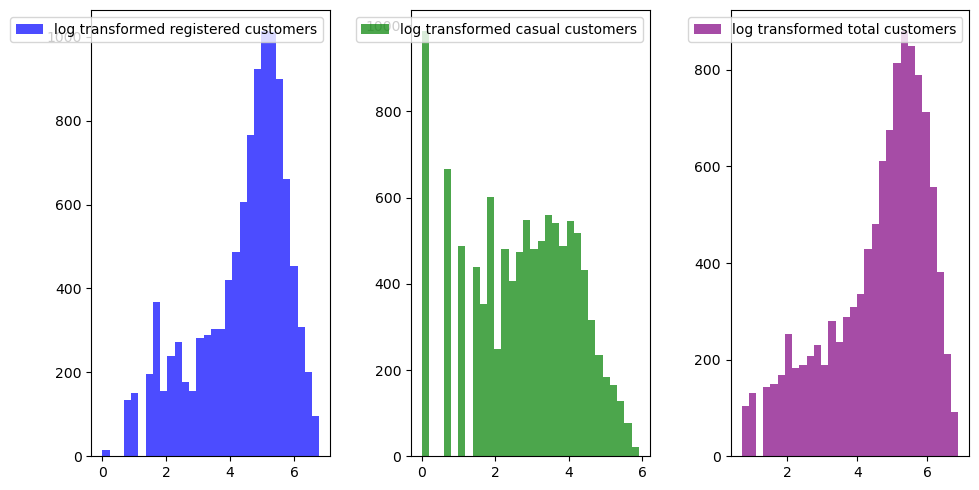

In [31]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.hist(np.log1p(train["registered"]), bins=30, alpha=0.7, color='blue', label='log transformed registered customers')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(np.log1p(train['casual']), bins=30, alpha=0.7, color='green', label='log transformed casual customers')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(np.log1p(train['count']), bins=30, alpha=0.7, color='purple', label='log transformed total customers')
plt.legend()


plt.tight_layout()
plt.show()

Log변환으로 Longtail을 제거해 예측의 정확도를 올릴 수 있음!

In [32]:
train["registered"] = np.log1p(train["registered"])
train["casual"] = np.log1p(train["casual"])
train["count"] = np.log1p(train["count"])

### Modeling

모든 모델을 Count를 예측하는 모델과 Casual, Registered를 각각 예측해서 합치는 모델 두 가지로 구성!

1. 단순 선형 회귀 모델 (선형회귀 모델에 들어가기 전 scaling!)
    - baseline
    - ElasticNet 
    
2. 트리 기반 모델
    - Random Forest Regression
    - Gradient Boosting
    - Cat Boost 

회귀 데이터 전처리 (rtrain)
1. 카테고리 변수 Encoding
2. train - validation set 분리.
3. Scaling

+ 교호 작용 판단을 위한 데이터셋 만들기

In [33]:
rtrain = pd.get_dummies(train, columns=["season", "weather"], drop_first=True, dtype=int)
rtest = pd.get_dummies(test, columns=["season", "weather"], drop_first=True, dtype=int)

rtrain["workingtemp"] = rtrain["temp"] * rtrain["workingday"]
rtest["workingtemp"] = rtest["temp"] * rtest["workingday"]

rtrain['weekday'].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],[0, 1,2,3,4,5,6], inplace=True)
rtest['weekday'].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],[0, 1,2,3,4,5,6], inplace=True)

In [34]:
from sklearn.model_selection import train_test_split

rtrain_full = rtrain
rtrain, rval = train_test_split(rtrain, test_size=0.2, random_state=127, shuffle=True)

rtrain_y_count = rtrain["count"]
rtrain_y_registered = rtrain["registered"]
rtrain_y_casual = rtrain["casual"]

rval_y_count = rval["count"]
rval_y_registered = rval["registered"]
rval_y_casual = rval["casual"]

rtrain = rtrain.drop(["datetime","casual","registered","count"], axis=1)
rval = rval.drop(["datetime","casual","registered","count"], axis=1)

In [35]:
itrain = rtrain.copy()
ival = rval.copy()

rtrain = rtrain.drop(["workingtemp"], axis=1)
rval = rval.drop(["workingtemp"], axis=1)

In [36]:
from sklearn.preprocessing import StandardScaler

scaler1 = StandardScaler()
scaled_train = scaler1.fit_transform(rtrain)
scaled_val = scaler1.transform(rval)

scaler2 = StandardScaler()
scaled_itrain = scaler2.fit_transform(itrain)
scaled_ival = scaler2.transform(ival)

##### 교호작용 없는 단순 선형 모델 : Count 직접 예측

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

lr = LinearRegression()

lr.fit(scaled_train,rtrain_y_count)

preds = lr.predict(scaled_val)

print('RMSLE Value For Linear Regression: {}'.format(np.sqrt(mse(rval_y_count, preds))))

RMSLE Value For Linear Regression: 0.9946758753628677


##### 교호작용 없는 단순 선형 모델 : Casual 과 Registered 따로 예측

In [38]:
from sklearn.linear_model import LinearRegression

lr1 = LinearRegression()
lr2 = LinearRegression()

lr1.fit(scaled_train, rtrain_y_casual)
lr2.fit(scaled_train, rtrain_y_registered)

preds1= lr1.predict(scaled_val)
preds2 = lr2.predict(scaled_val)

print('RMSLE Value For Linear Regression: {}'.format(np.sqrt(mse(rval_y_count, np.log1p(np.expm1(preds1)+ np.expm1(preds2))))))

RMSLE Value For Linear Regression: 0.9916565529540777


In [39]:
pd.DataFrame({"combine" : lr.coef_, "causal" : lr1.coef_, "registered" : lr2.coef_}, index=rtrain.columns)

,combine,causal,registered
holiday,0.009912,-0.032133,0.020108
workingday,0.019597,-0.312752,0.097308
temp,0.482261,0.827654,0.398201
humidity,-0.261777,-0.364737,-0.234411
windspeed,0.019031,0.002371,0.023455
weekday,0.072315,0.044862,0.081567
year,0.204359,0.095678,0.224442
month,0.219661,0.177541,0.225789
day,0.014109,0.024783,0.013184
hour,0.673146,0.510333,0.684760


In [40]:
from sklearn.linear_model import ElasticNet

alpha= 0.01
ratios = [0.1, 0.2, 0.4,0.6,0.8]

for ratio in ratios:
    elasticnet = ElasticNet(alpha=alpha, l1_ratio=ratio)
    elasticnet.fit(scaled_train,rtrain_y_count)
    pred = elasticnet.predict(scaled_val)
    print('RMSLE Value For ElasticNet: {}'.format(np.sqrt(mse(rval_y_count, pred))))    

RMSLE Value For ElasticNet: 0.9939302759404419
RMSLE Value For ElasticNet: 0.9937157487049902
RMSLE Value For ElasticNet: 0.993457419778797
RMSLE Value For ElasticNet: 0.9933468876726577
RMSLE Value For ElasticNet: 0.9933189397665942


In [41]:
for ratio in ratios:

    elasticnet1 = ElasticNet(alpha=alpha, l1_ratio=ratio)
    elasticnet2 = ElasticNet(alpha=alpha, l1_ratio=ratio)

    elasticnet1.fit(scaled_train,rtrain_y_casual)
    elasticnet2.fit(scaled_train, rtrain_y_registered)

    preds1= elasticnet1.predict(scaled_val)
    preds2 = elasticnet2.predict(scaled_val)

    print('RMSLE Value For ElasticNet: {}'.format(np.sqrt(mse(rval_y_count, np.log1p(np.expm1(preds1)+ np.expm1(preds2))))))

RMSLE Value For ElasticNet: 0.9910766594655631
RMSLE Value For ElasticNet: 0.9908975313042228
RMSLE Value For ElasticNet: 0.9906168700782385
RMSLE Value For ElasticNet: 0.9904484698644981
RMSLE Value For ElasticNet: 0.9903781549741497


##### 교호작용 있는 단순 선형 모델 : Count 직접 예측

In [42]:
from sklearn.linear_model import LinearRegression

ilr = LinearRegression()

ilr.fit(scaled_itrain,rtrain_y_count)

ipreds = ilr.predict(scaled_ival)

print('RMSLE Value For LR with intersection: {}'.format(np.sqrt(mse(rval_y_count, ipreds))))    

RMSLE Value For LR with intersection: 0.9948641980215946


##### 교호작용 있는 단순 선형 모델 : Casual 과 Registered 따로 예측

In [43]:
from sklearn.linear_model import LinearRegression

ilr1 = LinearRegression()
ilr2 = LinearRegression()

ilr1.fit(scaled_itrain, rtrain_y_casual)
ilr2.fit(scaled_itrain, rtrain_y_registered)

ipreds1= ilr1.predict(scaled_ival)
ipreds2 = ilr2.predict(scaled_ival)

print('RMSLE Value For LR with intersection: {}'.format(np.sqrt(mse(rval_y_count, np.log1p(np.expm1(ipreds1)+ np.expm1(ipreds2))))))

RMSLE Value For LR with intersection: 0.9923062286697435


Ensemble Model

Random Forest Model with Grid Search CV

In [44]:
train['weekday'].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],[0, 1,2,3,4,5,6], inplace=True)
test['weekday'].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],[0, 1,2,3,4,5,6], inplace=True)

etrain, eval = train_test_split(train, test_size=0.2, random_state=127, shuffle=True)

etrain_y_count = etrain["count"]
etrain_y_registered = etrain["registered"]
etrain_y_casual = etrain["casual"]

eval_y_count = eval["count"]

train_y_count = train["count"]
train_y_registered = train["registered"]
train_y_casual = train["casual"]

etrain = etrain.drop(["datetime","casual","registered","count"], axis=1)
eval = eval.drop(["datetime","casual","registered","count"], axis=1)

In [45]:
# from sklearn.model_selection import cross_val_score

# m = 1
# num = 0 

# for i in range(1,210,10) :
    
#     rf = RandomForestRegressor(n_estimators=i) 

#     score = cross_val_score(rf, train, train_y_count, scoring='neg_root_mean_squared_error', cv=5)

#     if np.mean(score)*(-1) < m : 

#         m,num  = (-1) * np.mean(score), i

#     print(np.mean(score)*-1)

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()

rf_params = {'n_estimators':[1,10,30,50,70,100], "max_depth":[5,10,15,20,25]}

grid_rf = GridSearchCV(rf,rf_params,scoring= "neg_root_mean_squared_error",cv=3 )
grid_rf.fit(etrain,etrain_y_count)

preds = grid_rf.predict(eval)
print('RMSLE Value For RandomForest: {}'.format(np.sqrt(mse(eval_y_count, preds))))    

RMSLE Value For RandomForest: 0.28614572439147384


In [47]:
grid_rf.best_params_

{'max_depth': 25, 'n_estimators': 100}

In [48]:
rf1 = RandomForestRegressor()
rf2 = RandomForestRegressor()

grid_rf1 = GridSearchCV(rf1,rf_params,scoring= "neg_mean_squared_error",cv=3)
grid_rf1.fit(etrain,etrain_y_casual)
preds1= grid_rf1.predict(eval)

grid_rf2 = GridSearchCV(rf2,rf_params,scoring="neg_mean_squared_error" ,cv= 3)
grid_rf2.fit(etrain,etrain_y_registered)
preds2 = grid_rf2.predict(eval)

print('RMSLE Value For RandomForest: {}'.format(np.sqrt(mse(eval_y_count, np.log1p(np.expm1(preds1)+ np.expm1(preds2))))))

RMSLE Value For RandomForest: 0.28150072297422324


In [49]:
print(grid_rf1.best_params_)
print(grid_rf2.best_params_)

{'max_depth': 15, 'n_estimators': 100}
{'max_depth': 20, 'n_estimators': 100}


In [50]:
train_ = train.drop(["datetime","casual","registered","count"],axis=1)
test_ = test.drop(["datetime"],axis=1)

In [51]:
preds1 = grid_rf1.best_estimator_.fit(train_,train_y_casual).predict(test_)
preds2 = grid_rf2.best_estimator_.fit(train_,train_y_registered).predict(test_)

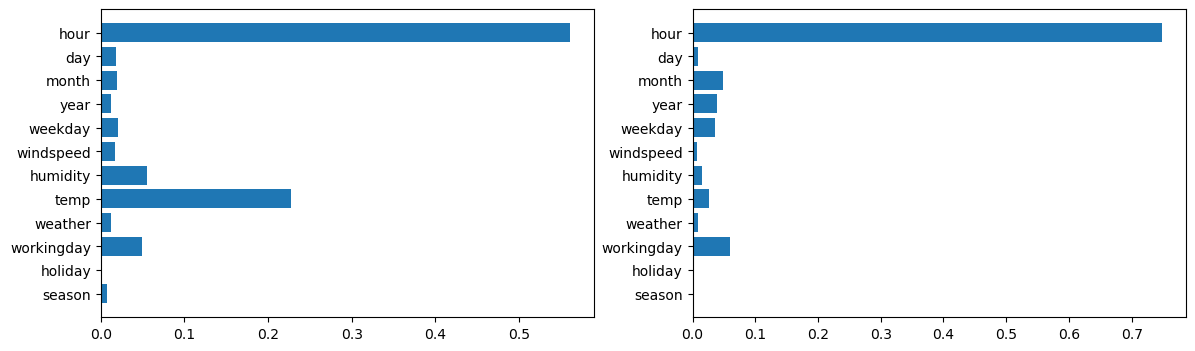

In [52]:
fig = plt.figure(figsize=[14,4])

ax1 = fig.add_subplot(1,2,1)
ax1 = plt.barh(train_.columns, grid_rf1.best_estimator_.feature_importances_, align='center')

ax2 = fig.add_subplot(1,2,2)
ax2 = plt.barh(train_.columns, grid_rf2.best_estimator_.feature_importances_, align='center')

In [53]:
sub = pd.read_csv("./bike-sharing-demand/sampleSubmission.csv")

sub["count"] = np.expm1(preds1) + np.expm1(preds2)

sub.to_csv('RandomForestSplitGridSearch.csv', index=False)

Gradient Boosting with Random Search CV

In [54]:
train["season"] = train["month"].apply(lambda x: 3 if x//3 == 1 else(1 if x//3 == 2 else (2 if x//3 == 3 else 4)))
test["season"] = test["month"].apply(lambda x: 3 if x//3 == 1 else(1 if x//3 == 2 else (2 if x//3 == 3 else 4)))

In [55]:
# train = train.drop(["day"], axis=1)
# test = test.drop(["day"], axis=1)

etrain, eval = train_test_split(train, test_size=0.2, random_state=127, shuffle=True)

etrain_y_count = etrain["count"]
etrain_y_registered = etrain["registered"]
etrain_y_casual = etrain["casual"]

eval_y_count = eval["count"]

train_y_count = train["count"]
train_y_registered = train["registered"]
train_y_casual = train["casual"]

etrain = etrain.drop(["datetime","casual","registered","count","month"], axis=1)
eval = eval.drop(["datetime","casual","registered","count","month"], axis=1)

In [56]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {'n_estimators':np.random.randint(100, 300, 20),
                       'learning_rate':np.random.uniform(low=0.05, high=0.3, size=20)}
 
gb = GradientBoostingRegressor(random_state=27)

random_gb = RandomizedSearchCV(gb,
                         param_distributions=param_distributions,
                         n_iter=20, n_jobs=-1,
                         scoring='neg_root_mean_squared_error',
                         cv=3, verbose=1, random_state=27)

random_gb.fit(etrain, etrain_y_count)

preds = random_gb.predict(eval)

print('RMSLE Value For GradientBoost: {}'.format(np.sqrt(mse(eval_y_count, preds))))  

Fitting 3 folds for each of 20 candidates, totalling 60 fits
RMSLE Value For GradientBoost: 0.3127824185114629


In [57]:
random_gb.best_params_

{'n_estimators': 238, 'learning_rate': 0.27885031752953093}

In [58]:
gb1 = GradientBoostingRegressor(random_state=27)

random_gb1 = RandomizedSearchCV(gb1,
                         param_distributions=param_distributions,
                         n_iter=20, n_jobs=-1,
                         scoring='neg_root_mean_squared_error',
                         cv=3, verbose=1, random_state=27)


gb2 = GradientBoostingRegressor(random_state=27)

random_gb2= RandomizedSearchCV(gb2,
                         param_distributions=param_distributions,
                         n_iter=20, n_jobs=-1,
                         scoring='neg_root_mean_squared_error',
                         cv=3, verbose=1, random_state=27)


random_gb1.fit(etrain, etrain_y_casual)
random_gb2.fit(etrain, etrain_y_registered)

preds1 = random_gb1.predict(eval)
preds2 = random_gb2.predict(eval)

print('RMSLE Value For GradientBoosting: {}'.format(np.sqrt(mse(eval_y_count, np.log1p(np.expm1(preds1)+ np.expm1(preds2))))))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
RMSLE Value For GradientBoosting: 0.30706741836398294


In [59]:
print(random_gb1.best_params_)
print(random_gb2.best_params_)

{'n_estimators': 238, 'learning_rate': 0.27885031752953093}
{'n_estimators': 238, 'learning_rate': 0.27885031752953093}


In [60]:
train_ = train_.drop(["month"],axis=1)
test_ = test_.drop(["month"],axis=1)

In [61]:
preds = grid_rf.best_estimator_.fit(train_, train_y_count).predict(test_)

In [62]:
sub = pd.read_csv("./bike-sharing-demand/sampleSubmission.csv")

sub["count"] = np.expm1(preds)

sub.to_csv('GradientBoostRandomSearch.csv', index=False)

In [63]:
preds1 = grid_rf1.best_estimator_.fit(train_,train_y_casual).predict(test_)
preds2 = grid_rf2.best_estimator_.fit(train_,train_y_registered).predict(test_)

In [64]:
sub = pd.read_csv("./bike-sharing-demand/sampleSubmission.csv")

sub["count"] = np.expm1(preds1) + np.expm1(preds2)

sub.to_csv('GradientBoostSplitRandomSearch.csv', index=False)

In [65]:
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

cb = CatBoostRegressor(silent=True, random_state=27)

random_cb = RandomizedSearchCV(cb,
                         param_distributions=param_distributions,
                         n_iter=20, n_jobs=-1,
                         scoring='neg_root_mean_squared_error',
                         cv=3, verbose=1, random_state=27)

random_cb.fit(etrain, etrain_y_count, cat_features= [0,1,2,3,7])

preds = random_cb.predict(eval)

print('RMSLE Value For CatBoost: {}'.format(np.sqrt(mse(eval_y_count, preds))))  

Fitting 3 folds for each of 20 candidates, totalling 60 fits
RMSLE Value For CatBoost: 0.2947313747934513


In [66]:
random_cb.best_params_

{'n_estimators': 238, 'learning_rate': 0.27885031752953093}

In [67]:
cb1 = CatBoostRegressor(silent=True, random_state=27)

random_cb1 = RandomizedSearchCV(cb1,
                         param_distributions=param_distributions,
                         n_iter=20, n_jobs=-1,
                         scoring='neg_root_mean_squared_error',
                         cv=3, verbose=1, random_state=27)


cb2 = CatBoostRegressor(silent=True, random_state=27)

random_cb2= RandomizedSearchCV(cb2,
                         param_distributions=param_distributions,
                         n_iter=20, n_jobs=-1,
                         scoring='neg_root_mean_squared_error',
                         cv=3, verbose=1, random_state=27)


random_cb1.fit(etrain, etrain_y_casual, cat_features= [0,1,2,3,7])
random_cb2.fit(etrain, etrain_y_registered, cat_features= [0,1,2,3,7])

preds1 = random_cb1.predict(eval)
preds2 = random_cb2.predict(eval)

print('RMSLE Value For CatBoost: {}'.format(np.sqrt(mse(eval_y_count, np.log1p(np.expm1(preds1)+ np.expm1(preds2))))))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
RMSLE Value For CatBoost: 0.295112192234761


In [68]:
print(random_gb1.best_params_)
print(random_gb2.best_params_)

{'n_estimators': 238, 'learning_rate': 0.27885031752953093}
{'n_estimators': 238, 'learning_rate': 0.27885031752953093}


In [69]:
preds1 = grid_rf1.best_estimator_.fit(train_,train_y_casual).predict(test_)
preds2 = grid_rf2.best_estimator_.fit(train_,train_y_registered).predict(test_)

In [70]:
sub = pd.read_csv("./bike-sharing-demand/sampleSubmission.csv")

sub["count"] = np.expm1(preds1) + np.expm1(preds2)

sub.to_csv('CatBoostSplitRandomSearch.csv', index=False)